# Distributed quadratic programming

This is the script for the numerical experiment in the paper ...

## Set some important directories path (**compulsory**):

In [20]:
if __name__ == "__main__":
    import os

    script_dir = os.getcwd()
    data_dir = os.path.join(script_dir, "data")
    figure_dir = os.path.join(script_dir, "figures")
    results_dir = os.path.join(script_dir, "results")

    os.makedirs(figure_dir, exist_ok=True)
    os.makedirs(results_dir, exist_ok=True)

## Problem formulation:
$$
\begin{split}
    \min_{\boldsymbol{x}_{1}, \ldots, \boldsymbol{x}_{9}} \quad &\sum_{i \in \mathcal{I}}\left( \frac{1}{2}\boldsymbol{x}_{i}^{\top}Q_{i}\boldsymbol{x}_{i} + \boldsymbol{g}_{i}^{\top}\boldsymbol{x}_{i} \right)\\
    \text{s.t.} \quad
    &\begin{cases}
        \sum_{i \in \mathcal{I}}\boldsymbol{a}_{i, 1}^{\top}\boldsymbol{x}_{i} \leq b_{1}(D) \\
        \sum_{i \in \mathcal{I}}\boldsymbol{a}_{i, 2}^{\top}\boldsymbol{x}_{i} \leq b_{2}(D) \\
        \sum_{i \in \mathcal{I}}\boldsymbol{a}_{i, 3}^{\top}\boldsymbol{x}_{i} \leq b_{3}(D)
    \end{cases}
\end{split}
$$

### Load data (**compulsory**):

In [21]:
if __name__ == "__main__":
    import numpy as np
    from typing import Dict
    from numpy.typing import NDArray

    node_names = ["1", "2", "3", "4", "5", "6", "7", "8", "9"]

    Q: Dict[str, NDArray[np.float64]] = np.load(os.path.join(data_dir, "Q.npz"))
    g: Dict[str, NDArray[np.float64]] = np.load(os.path.join(data_dir, "g.npz"))
    A: Dict[str, NDArray[np.float64]] = np.load(os.path.join(data_dir, "A.npz"))

    D: NDArray[np.float64] = np.load(os.path.join(data_dir, "D.npy"))

    proportion_of_1 = D[np.where(D == 1)].size / 1000
    proportion_of_2 = D[np.where(D == 2)].size / 1000
    proportion_of_3 = D[np.where(D == 3)].size / 1000

    b: NDArray[np.float64] = np.array(
        [proportion_of_1, proportion_of_2, proportion_of_3]
    )

### Run centralized optimization (**compulsory**):

In [22]:
if __name__ == "__main__":
    import cvxpy as cp

    x: dict[str, cp.Variable] = {i: cp.Variable(A[i].shape[1]) for i in node_names}

    cost = cp.sum([x[i] @ Q[i] @ x[i] / 2 + g[i] @ x[i] for i in node_names])
    constraints: list[cp.Constraint] = [
        sum([A[i] @ x[i] for i in node_names], start=cp.Constant(0)) <= b
    ]

    problem = cp.Problem(cp.Minimize(cost), constraints)
    problem.solve(solver="OSQP")

    opt_val: np.float64 = problem.value  # type: ignore

    print(f"Centralized optimal value: {opt_val}")

Centralized optimal value: -60.92641675724471


### Run sensitivity analysis:

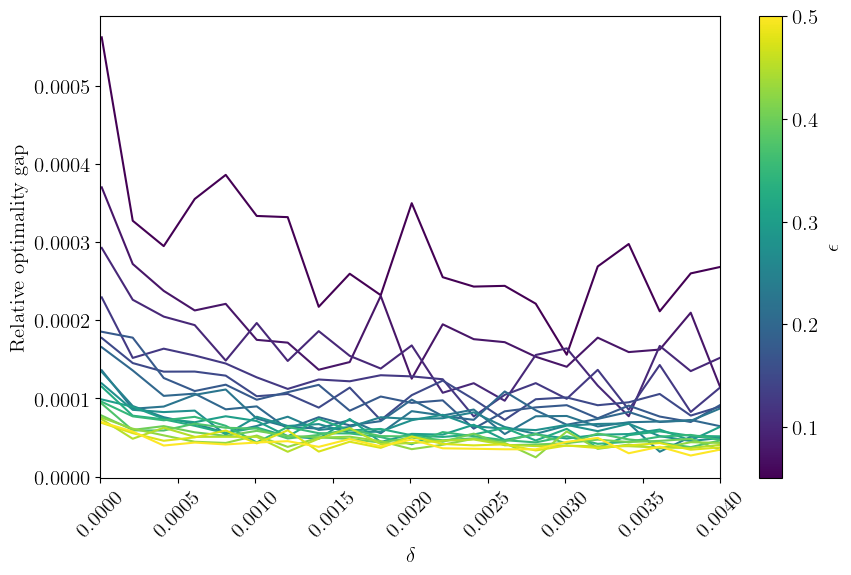

In [23]:
if __name__ == "__main__":
    import matplotlib.pyplot as plt
    from pdra import TruncatedLaplace

    x: dict[str, cp.Variable] = {i: cp.Variable(A[i].shape[1]) for i in node_names}
    b_bar = cp.Parameter(b.size)

    cost = cp.sum([x[i] @ Q[i] @ x[i] / 2 + g[i] @ x[i] for i in node_names])
    constraints: list[cp.Constraint] = [
        sum([A[i] @ x[i] for i in node_names], start=cp.Constant(0)) <= b_bar
    ]

    problem = cp.Problem(cp.Minimize(cost), constraints)

    epsilons = np.arange(0.05, 0.525, 0.025)
    deltas = np.arange(1e-5, 0.0042 + 1e-5, 0.0002)
    Delta = 0.002

    n_eps = epsilons.size
    n_del = deltas.size
    n_samples = n_eps * n_del
    run_times = 50

    Eps, Del = np.meshgrid(epsilons, deltas, indexing="ij")
    param_pairs = np.dstack((Eps, Del)).reshape(-1, 2)

    opt_perturb = np.zeros((n_samples, run_times))

    for i in range(n_samples):
        epsilon, delta = param_pairs[i]
        s = (Delta / epsilon) * np.log(b.size * (np.exp(epsilon) - 1) / delta + 1)
        tl = TruncatedLaplace(-s, s, 0, Delta / epsilon)

        perturbation = -s * np.ones(b.size) + tl.sample(b.size)
        b_bar.value = b + perturbation

        for j in range(run_times):
            problem.solve(solver="OSQP")
            opt_perturb[i, j] = problem.value  # type: ignore

    rel_opt_gap: NDArray[np.float64] = np.abs(
        (np.mean(opt_perturb, axis=1) - opt_val) / opt_val
    )
    rel_opt_gap = rel_opt_gap.reshape(n_eps, n_del)

    fig1, ax1 = plt.subplots(figsize=(10, 6))

    import matplotlib as mpl
    import matplotlib.cm as cm
    import matplotlib.colors as mcolors

    cmap = mpl.colormaps["viridis"]
    norm = mcolors.Normalize(vmin=epsilons.min(), vmax=epsilons.max())

    for i in range(n_eps):
        color = cmap(norm(epsilons[i]))
        ax1.plot(
            deltas,
            rel_opt_gap[i, :],
            label=f"$\\epsilon = {epsilons[i]:.2f}$",
            color=color,
        )

    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig1.colorbar(sm, ax=ax1, orientation="vertical")
    cbar.set_label("$\\epsilon$")
    ax1.set_xlim(0.0, 0.004)
    ax1.tick_params(axis="x", rotation=45)
    ax1.set_xlabel("$\\delta$")
    ax1.set_ylabel("Relative optimality gap")

    plt.show()

### Run distributed optimization:
#### Resource perturbation:

In [26]:
if __name__ == "__main__":
    algorithm = "core"  # "core" or "rsdd"

    epsilon = 0.5
    delta = 0.005
    Delta = 0.002

    np.random.seed(0)

    perturbation: NDArray[np.float64]

    if algorithm == "core":
        from pdra import TruncatedLaplace

        s = (Delta / epsilon) * np.log(b.size * (np.exp(epsilon) - 1) / delta + 1)
        tl = TruncatedLaplace(-s, s, 0, Delta / epsilon)
        perturbation = -s * np.ones(b.size) + tl.sample(b.size)

    elif algorithm == "rsdd":
        perturbation = np.random.laplace(0, Delta / epsilon, b.size)

    b_bar = b + perturbation

#### Resource allocation:

In [27]:
if __name__ == "__main__":
    from functools import partial
    from pdra import Node

    node_params = {
        "core": {
            "max_iter": 2000,
            "step_size": 3.0,
            "method": "AGM",
            "solver": "OSQP",
            "results_prefix": os.path.join(results_dir, "core"),
        },
        "rsdd": {
            "max_iter": 2000,
            "step_size": 300.0,
            "solver": "OSQP",
            "results_prefix": os.path.join(results_dir, "rsdd"),
            "decay_rate": 0.9,
            "penalty_factor": 1e3,
        },
    }

    def f(x: cp.Variable, index: str) -> cp.Expression:
        return x @ Q[index] @ x / 2 + g[index] @ x

    nodes = [
        Node.create(algorithm, i, partial(f, index=i), A[i], **node_params[algorithm])
        for i in node_names
    ]

    nodes[0].set_resource(b_bar)

    for node in nodes:
        node.start()

    for node in nodes:
        node.join()

## Set up latex options for matplotlib (**compulsory**):

In [28]:
if __name__ == "__main__":
    import matplotlib.pyplot as plt

    plt.rcParams["text.usetex"] = True
    plt.rcParams["text.latex.preamble"] = "\\usepackage{amsmath}"
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.serif"] = "Times New Roman"
    plt.rcParams["font.size"] = 15

## Results plot:
- Load results:

In [29]:
if __name__ == "__main__":
    iterations = np.arange(1, node_params["core"]["max_iter"] + 1)

    results = {
        "core": {
            i: np.load(node_params["core"]["results_prefix"] + f"/node_{i}.npz")
            for i in node_names
        },
        "rsdd": {
            i: np.load(node_params["rsdd"]["results_prefix"] + f"/node_{i}.npz")
            for i in node_names
        },
    }

- Error evolution:

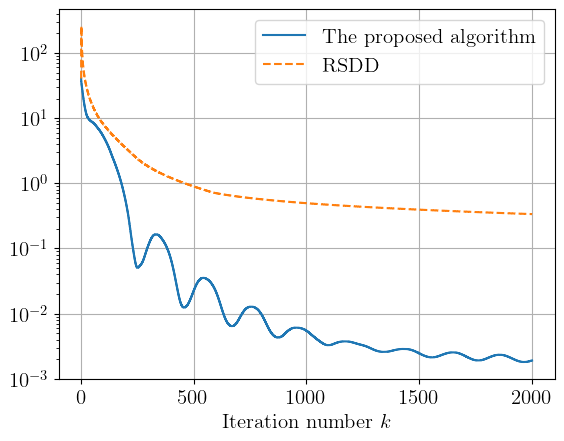

In [30]:
if __name__ == "__main__":
    fig2, ax2 = plt.subplots()

    err_series = {
        "core": sum([results["core"][i]["f_i_series"] for i in node_names]) - opt_val,
        "rsdd": sum([results["rsdd"][i]["f_i_series"] for i in node_names]) - opt_val,
    }

    ax2.step(
        iterations,
        err_series["core"],
        label="The proposed algorithm",
        color="tab:blue",
        linestyle="-",
    )

    ax2.step(
        iterations,
        err_series["rsdd"],
        label="RSDD",
        color="tab:orange",
        linestyle="--",
    )

    ax2.set_xlabel("Iteration number $k$")
    ax2.set_yscale("log")
    ax2.legend()
    ax2.grid()

    plt.show()

- Constraints violation:

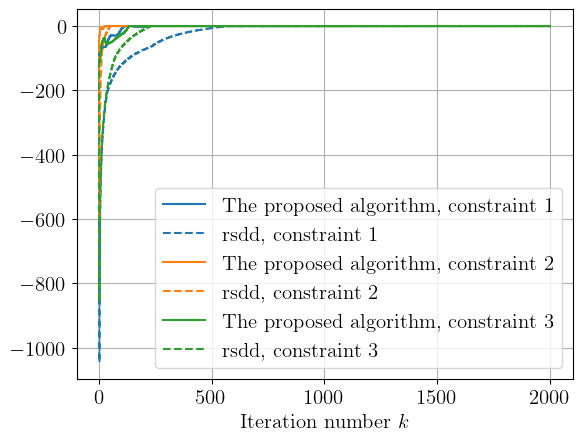

In [31]:
if __name__ == "__main__":
    fig3, ax3 = plt.subplots()

    colors = {
        "1": "tab:blue",
        "2": "tab:orange",
        "3": "tab:green",
        "4": "tab:red",
        "5": "tab:purple",
        "6": "tab:brown",
        "7": "tab:pink",
        "8": "tab:gray",
        "9": "tab:olive",
    }

    constraint_values = {
        "core": sum([A[i] @ results["core"][i]["x_i_series"] for i in node_names])
        - b[:, np.newaxis],
        "rsdd": sum([A[i] @ results["rsdd"][i]["x_i_series"] for i in node_names])
        - b[:, np.newaxis],
    }

    for i in range(constraint_values["core"].shape[0]):
        ax3.step(
            iterations,
            constraint_values["core"][i],
            linestyle="-",
            color=colors[str(i + 1)],
            label=f"The proposed algorithm, constraint {i + 1}",
        )
        ax3.step(
            iterations,
            constraint_values["rsdd"][i],
            linestyle="--",
            color=colors[str(i + 1)],
            label=f"rsdd, constraint {i + 1}",
        )

    ax3.set_xlabel("Iteration number $k$")
    ax3.legend()
    ax3.grid()

    plt.show()

- Computation time:

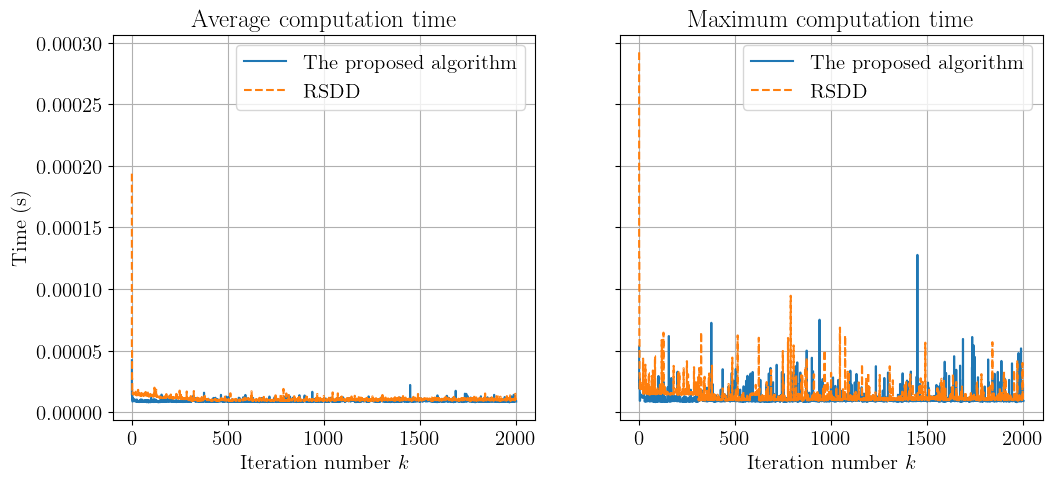

In [32]:
if __name__ == "__main__":
    fig4, ax4 = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

    from matplotlib.axes import Axes

    ax4_0: Axes = ax4[0]
    ax4_1: Axes = ax4[1]

    computation_times = {
        "core": np.vstack([results["core"][i]["computation_time"] for i in node_names]),
        "rsdd": np.vstack([results["rsdd"][i]["computation_time"] for i in node_names]),
    }

    avg_times = {
        "core": np.mean(computation_times["core"], axis=0),
        "rsdd": np.mean(computation_times["rsdd"], axis=0),
    }

    max_times = {
        "core": np.max(computation_times["core"], axis=0),
        "rsdd": np.max(computation_times["rsdd"], axis=0),
    }

    # Average computation time (left)
    ax4_0.step(
        iterations,
        avg_times["core"],
        label="The proposed algorithm",
        color="tab:blue",
        linestyle="-",
    )
    ax4_0.step(
        iterations,
        avg_times["rsdd"],
        label="RSDD",
        color="tab:orange",
        linestyle="--",
    )
    ax4_0.set_xlabel("Iteration number $k$")
    ax4_0.set_ylabel("Time (s)")
    ax4_0.set_title("Average computation time")
    ax4_0.legend()
    ax4_0.grid()

    # Maximum computation time (right)
    ax4_1.step(
        iterations,
        max_times["core"],
        label="The proposed algorithm",
        color="tab:blue",
        linestyle="-",
    )
    ax4_1.step(
        iterations,
        max_times["rsdd"],
        label="RSDD",
        color="tab:orange",
        linestyle="--",
    )
    ax4_1.set_xlabel("Iteration number $k$")
    ax4_1.set_title("Maximum computation time")
    ax4_1.legend()
    ax4_1.grid()

    plt.show()

## Save the figures:

In [33]:
if __name__ == "__main__":
    fig1.savefig(
        os.path.join(figure_dir, "sensitivity_analysis.pdf"),
        format="pdf",
        bbox_inches="tight",
    )
    fig2.savefig(
        os.path.join(figure_dir, "fig_3_a.pdf"), format="pdf", bbox_inches="tight"
    )
    fig3.savefig(
        os.path.join(figure_dir, "fig_3_b.pdf"), format="pdf", bbox_inches="tight"
    )
    fig4.savefig(
        os.path.join(figure_dir, "dqp_time_comparison.pdf"),
        format="pdf",
        bbox_inches="tight",
    )